<a href="https://colab.research.google.com/github/MatheusHenriqueDaSilva/data_science/blob/main/pro_acoes_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import joblib
from sklearn.model_selection import train_test_split
import yaml
import shap
pd.set_option('display.max_columns', None)

##!pip install pandas pyarrow fastparquet

In [ ]:
tamanho_campos=[2,8,2,12,3,12,10,3,4,13,13,13,13,13,13,13,5,18,18,13,1,8,7,13,12,3]
ANOS=[2018,2019,2020,2021,2022,2023,2024]
dados = {}  # Dicionário para armazenar os DataFrames

for ano in ANOS:
  dados[f'data_{ano}'] = pd.read_fwf(f'/content/COTAHIST_A{ano}.TXT', widths=tamanho_campos, header=0)

  ## Nomear as colunas

  dados[f'data_{ano}'].columns = [
  "tipo_registro",
  "data_pregao",
  "cod_bdi",
  "cod_negociacao",
  "tipo_mercado",
  "noma_empresa",
  "especificacao_papel",
  "prazo_dias_merc_termo",
  "moeda_referencia",
  "preco_abertura",
  "preco_maximo",
  "preco_minimo",
  "preco_medio",
  "preco_ultimo_negocio",
  "preco_melhor_oferta_compra",
  "preco_melhor_oferta_venda",
  "numero_negocios",
  "quantidade_papeis_negociados",
  "volume_total_negociado",
  "preco_exercicio",
  "ìndicador_correcao_precos",
  "data_vencimento" ,
  "fator_cotacao",
  "preco_exercicio_pontos",
  "codigo_isin",
  "num_distribuicao_papel"]

  # Eliminar a última linha
  linha=len(dados[f'data_{ano}']["data_pregao"])
  dados[f'data_{ano}']=dados[f'data_{ano}'].drop(linha-1)

  # Ajustar valores com virgula (dividir os valores dessas colunas por 100)
  listaVirgula=[
  "preco_abertura",
  "preco_maximo",
  "preco_minimo",
  "preco_medio",
  "preco_ultimo_negocio",
  "preco_melhor_oferta_compra",
  "preco_melhor_oferta_venda",
  "volume_total_negociado",
  "preco_exercicio",
  "preco_exercicio_pontos"
  ]

  for coluna in listaVirgula:
      dados[f'data_{ano}'][coluna]=[i/100. for i in dados[f'data_{ano}'][coluna]]

  dados[f'data_ITUB4_{ano}'] = dados[f'data_{ano}'][(dados[f'data_{ano}']['tipo_mercado']==10) & (dados[f'data_{ano}']['cod_negociacao'] == 'ITUB4')]
  dados[f'data_PETR4_{ano}'] = dados[f'data_{ano}'][(dados[f'data_{ano}']['tipo_mercado']==10) & (dados[f'data_{ano}']['cod_negociacao'] == 'PETR4')]
  # dados[f'data_full_{ano}'] = dados[f'data_{ano}'][(dados[f'data_{ano}']['tipo_mercado']==10)]


In [ ]:
data_itub4_save =  pd.concat([dados[f'data_ITUB4_2018'],dados[f'data_ITUB4_2019'],dados[f'data_ITUB4_2020'],dados[f'data_ITUB4_2021'],dados[f'data_ITUB4_2022'],dados[f'data_ITUB4_2023'],dados[f'data_ITUB4_2024']], axis = 0).reset_index()
data_PETR4_save =  pd.concat([dados[f'data_PETR4_2018'],dados[f'data_PETR4_2019'],dados[f'data_PETR4_2020'],dados[f'data_PETR4_2021'],dados[f'data_PETR4_2022'],dados[f'data_PETR4_2023'],dados[f'data_PETR4_2024']], axis = 0).reset_index()
data_itub4_save.to_parquet("data_itub4.parquet", engine="pyarrow", index=False)
data_PETR4_save.to_parquet("data_petr4.parquet", engine="pyarrow", index=False)


In [ ]:
dados['data_full_2024']['cod_negociacao'].unique()

array(['AALR3', 'ABCB4', 'ABEV3', ..., 'SOND3', 'BKCH39', 'GRUL11'],
      dtype=object)

In [3]:
data_itub4 = pd.read_parquet("data_itub4.parquet", engine="pyarrow").reset_index(drop=True)
data_petr4 = pd.read_parquet("data_petr4.parquet", engine="pyarrow").reset_index(drop=True)
data_itub4.head()

,index,tipo_registro,data_pregao,cod_bdi,cod_negociacao,tipo_mercado,noma_empresa,especificacao_papel,prazo_dias_merc_termo,moeda_referencia,preco_abertura,preco_maximo,preco_minimo,preco_medio,preco_ultimo_negocio,preco_melhor_oferta_compra,preco_melhor_oferta_venda,numero_negocios,quantidade_papeis_negociados,volume_total_negociado,preco_exercicio,ìndicador_correcao_precos,data_vencimento,fator_cotacao,preco_exercicio_pontos,codigo_isin,num_distribuicao_papel
0,1016,1,20180102,2.0,ITUB4,10,ITAUUNIBANCO,PN ED N1,NaN,R$,42.80,43.88,42.80,43.56,43.88,43.79,43.88,30810.0,11100600.0,483649086.0,0.0,0.0,99991231.0,1.0,0.0,BRITUBACNPR1,232.0
1,3099,1,20180103,2.0,ITUB4,10,ITAUUNIBANCO,PN ED N1,NaN,R$,43.90,44.34,43.57,44.01,44.18,44.17,44.18,18377.0,14863800.0,654269523.0,0.0,0.0,99991231.0,1.0,0.0,BRITUBACNPR1,232.0
2,5397,1,20180104,2.0,ITUB4,10,ITAUUNIBANCO,PN ED N1,NaN,R$,44.25,45.30,44.25,44.99,45.10,45.10,45.20,28294.0,15481700.0,696661801.0,0.0,0.0,99991231.0,1.0,0.0,BRITUBACNPR1,232.0
3,7763,1,20180105,2.0,ITUB4,10,ITAUUNIBANCO,PN ED N1,NaN,R$,45.12,45.32,44.60,45.08,45.23,45.20,45.23,19882.0,10478300.0,472439105.0,0.0,0.0,99991231.0,1.0,0.0,BRITUBACNPR1,232.0
4,10039,1,20180108,2.0,ITUB4,10,ITAUUNIBANCO,PN ED N1,NaN,R$,45.06,45.32,44.78,45.06,45.08,45.07,45.08,20228.0,8472100.0,381831069.0,0.0,0.0,99991231.0,1.0,0.0,BRITUBACNPR1,232.0


In [5]:
data_petr4.head()

,index,tipo_registro,data_pregao,cod_bdi,cod_negociacao,tipo_mercado,noma_empresa,especificacao_papel,prazo_dias_merc_termo,moeda_referencia,preco_abertura,preco_maximo,preco_minimo,preco_medio,preco_ultimo_negocio,preco_melhor_oferta_compra,preco_melhor_oferta_venda,numero_negocios,quantidade_papeis_negociados,volume_total_negociado,preco_exercicio,ìndicador_correcao_precos,data_vencimento,fator_cotacao,preco_exercicio_pontos,codigo_isin,num_distribuicao_papel
0,1329,1,20180102,2.0,PETR4,10,PETROBRAS,PN,NaN,R$,16.19,16.55,16.19,16.42,16.55,16.53,16.55,40660.0,33461800.0,549628149.0,0.0,0.0,99991231.0,1.0,0.0,BRPETRACNPR6,186.0
1,3463,1,20180103,2.0,PETR4,10,PETROBRAS,PN,NaN,R$,16.49,16.72,16.37,16.58,16.70,16.69,16.70,41425.0,55940900.0,927610016.0,0.0,0.0,99991231.0,1.0,0.0,BRPETRACNPR6,186.0
2,5776,1,20180104,2.0,PETR4,10,PETROBRAS,PN,NaN,R$,16.78,16.96,16.62,16.83,16.73,16.73,16.75,39461.0,37064900.0,624099864.0,0.0,0.0,99991231.0,1.0,0.0,BRPETRACNPR6,186.0
3,8115,1,20180105,2.0,PETR4,10,PETROBRAS,PN,NaN,R$,16.70,16.86,16.57,16.76,16.83,16.82,16.83,37542.0,26958200.0,452007598.0,0.0,0.0,99991231.0,1.0,0.0,BRPETRACNPR6,186.0
4,10412,1,20180108,2.0,PETR4,10,PETROBRAS,PN,NaN,R$,16.74,17.03,16.71,16.92,17.03,17.02,17.04,36507.0,28400000.0,480575914.0,0.0,0.0,99991231.0,1.0,0.0,BRPETRACNPR6,186.0


In [6]:
import pandas as pd
import sqlite3

# Lista de ações
lista_acoes = [ 'PETR4']#'ITUB4',

# Criando um dicionário para armazenar os DataFrames de cada ação
dict_dados = {'ITUB4': data_itub4, 'PETR4': data_petr4}

# Definindo o DataFrame inicial consolidado
data_consolidado = data_itub4.copy()

for acao in lista_acoes:
    con = sqlite3.connect(":memory:")  # Criando conexão temporária

    # Salvando DataFrame base no SQL
    data_consolidado.to_sql("data_consolidado", con, index=False, if_exists="replace")

    # Salvando o DataFrame da ação no SQL (usando dicionário para acessar os dados corretamente)
    dict_dados[acao].to_sql(f"data_{acao}", con, index=True, if_exists="replace")

    # Definindo as colunas para o JOIN
    chaves_join = ['data_pregao']
    condicao_join = " AND ".join([f"a.{col} = b.{col}" for col in chaves_join])  # Condição dinâmica


    # Criando a query SQL para LEFT JOIN
    query = f"""
    SELECT a.*, b.preco_ultimo_negocio as preco_ultimo_negocio_{acao},b.numero_negocios as numero_negocios_{acao}
    FROM data_consolidado AS a
    LEFT JOIN data_{acao} AS b
    ON {condicao_join}
    """

    # Executando a query e carregando os dados no Pandas
    data_consolidado = pd.read_sql(query, con)

    # Fechando conexão SQLite
    con.close()

# Exibindo resultado final
data_consolidado.head()

,index,tipo_registro,data_pregao,cod_bdi,cod_negociacao,tipo_mercado,noma_empresa,especificacao_papel,prazo_dias_merc_termo,moeda_referencia,preco_abertura,preco_maximo,preco_minimo,preco_medio,preco_ultimo_negocio,preco_melhor_oferta_compra,preco_melhor_oferta_venda,numero_negocios,quantidade_papeis_negociados,volume_total_negociado,preco_exercicio,ìndicador_correcao_precos,data_vencimento,fator_cotacao,preco_exercicio_pontos,codigo_isin,num_distribuicao_papel,preco_ultimo_negocio_PETR4,numero_negocios_PETR4
0,1016,1,20180102,2.0,ITUB4,10,ITAUUNIBANCO,PN ED N1,None,R$,42.80,43.88,42.80,43.56,43.88,43.79,43.88,30810.0,11100600.0,483649086.0,0.0,0.0,99991231.0,1.0,0.0,BRITUBACNPR1,232.0,16.55,40660.0
1,3099,1,20180103,2.0,ITUB4,10,ITAUUNIBANCO,PN ED N1,None,R$,43.90,44.34,43.57,44.01,44.18,44.17,44.18,18377.0,14863800.0,654269523.0,0.0,0.0,99991231.0,1.0,0.0,BRITUBACNPR1,232.0,16.70,41425.0
2,5397,1,20180104,2.0,ITUB4,10,ITAUUNIBANCO,PN ED N1,None,R$,44.25,45.30,44.25,44.99,45.10,45.10,45.20,28294.0,15481700.0,696661801.0,0.0,0.0,99991231.0,1.0,0.0,BRITUBACNPR1,232.0,16.73,39461.0
3,7763,1,20180105,2.0,ITUB4,10,ITAUUNIBANCO,PN ED N1,None,R$,45.12,45.32,44.60,45.08,45.23,45.20,45.23,19882.0,10478300.0,472439105.0,0.0,0.0,99991231.0,1.0,0.0,BRITUBACNPR1,232.0,16.83,37542.0
4,10039,1,20180108,2.0,ITUB4,10,ITAUUNIBANCO,PN ED N1,None,R$,45.06,45.32,44.78,45.06,45.08,45.07,45.08,20228.0,8472100.0,381831069.0,0.0,0.0,99991231.0,1.0,0.0,BRITUBACNPR1,232.0,17.03,36507.0


In [7]:
data_consolidado.shape


(1686, 29)

In [8]:
data_itub4.shape

(1686, 27)

In [ ]:
data_itub4.tail(
)

,index,tipo_registro,data_pregao,cod_bdi,cod_negociacao,tipo_mercado,noma_empresa,especificacao_papel,prazo_dias_merc_termo,moeda_referencia,preco_abertura,preco_maximo,preco_minimo,preco_medio,preco_ultimo_negocio,preco_melhor_oferta_compra,preco_melhor_oferta_venda,numero_negocios,quantidade_papeis_negociados,volume_total_negociado,preco_exercicio,ìndicador_correcao_precos,data_vencimento,fator_cotacao,preco_exercicio_pontos,codigo_isin,num_distribuicao_papel
1681,1347607,1,20241007,2.0,ITUB4,10,ITAUUNIBANCO,PN EJ N1,NaN,R$,35.20,35.32,34.85,35.11,35.14,35.13,35.15,22970.0,23310400.0,818620449.0,0.0,0.0,99991231.0,1.0,0.0,BRITUBACNPR1,342.0
1682,1349245,1,20241008,2.0,ITUB4,10,ITAUUNIBANCO,PN EJ N1,NaN,R$,34.93,35.52,34.90,35.36,35.35,35.35,35.37,33539.0,23103400.0,817031494.0,0.0,0.0,99991231.0,1.0,0.0,BRITUBACNPR1,342.0
1683,1351069,1,20241009,2.0,ITUB4,10,ITAUUNIBANCO,PN EJ N1,NaN,R$,35.11,35.20,34.63,34.85,34.70,34.70,34.75,35673.0,20924100.0,729268413.0,0.0,0.0,99991231.0,1.0,0.0,BRITUBACNPR1,342.0
1684,1352647,1,20241010,2.0,ITUB4,10,ITAUUNIBANCO,PN EJ N1,NaN,R$,34.71,34.97,34.57,34.81,34.89,34.88,34.90,27883.0,20487100.0,713223496.0,0.0,0.0,99991231.0,1.0,0.0,BRITUBACNPR1,342.0
1685,1354390,1,20241011,2.0,ITUB4,10,ITAUUNIBANCO,PN N1,NaN,R$,34.83,34.97,34.55,34.71,34.63,34.62,34.63,29848.0,16965500.0,588880130.0,0.0,0.0,99991231.0,1.0,0.0,BRITUBACNPR1,342.0


In [9]:
def generate_metadata(dataframe):

    metadata2 = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata2=metadata2.sort_values(by='tipo')
    metadata2 = metadata2.reset_index(drop=True)

    return metadata2

metadados = generate_metadata(data_consolidado)
metadados.head(50)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,index,int64,0,0.0,1686
1,tipo_registro,int64,0,0.0,1
2,tipo_mercado,int64,0,0.0,1
3,num_distribuicao_papel,float64,0,0.0,111
4,preco_exercicio_pontos,float64,0,0.0,1
5,fator_cotacao,float64,0,0.0,1
6,data_vencimento,float64,0,0.0,1
7,ìndicador_correcao_precos,float64,0,0.0,1
8,preco_exercicio,float64,0,0.0,1
9,volume_total_negociado,float64,0,0.0,1686


# Nova seção

In [125]:
lista_spec = ['quantidade_papeis_negociados','numero_negocios','preco_melhor_oferta_venda','preco_melhor_oferta_compra',
              'preco_medio','preco_minimo','preco_maximo','preco_abertura','num_distribuicao_papel','preco_ultimo_negocio','preco_ultimo_negocio_PETR4','numero_negocios_PETR4']

data_itub4_clean = data_consolidado.loc[:,lista_spec]
data_itub4_clean.shape



(1686, 12)

In [126]:

for i in lista_spec:
  data_itub4_clean[f'max20_{i}'] = data_itub4_clean[f'{i}'].rolling(window=20).max().fillna(0)
  data_itub4_clean[f'max60_{i}'] = data_itub4_clean[f'{i}'].rolling(window=60).max().fillna(0)
  data_itub4_clean[f'max120_{i}'] = data_itub4_clean[f'{i}'].rolling(window=120).max().fillna(0)
  data_itub4_clean[f'max240_{i}'] = data_itub4_clean[f'{i}'].rolling(window=240).max().fillna(0)
  data_itub4_clean[f'max480_{i}'] = data_itub4_clean[f'{i}'].rolling(window=480).max().fillna(0)
  data_itub4_clean[f'max720_{i}'] = data_itub4_clean[f'{i}'].rolling(window=720).max().fillna(0)
  data_itub4_clean[f'min20_{i}'] = data_itub4_clean[f'{i}'].rolling(window=20).min().fillna(0)
  data_itub4_clean[f'min60_{i}'] = data_itub4_clean[f'{i}'].rolling(window=60).min().fillna(0)
  data_itub4_clean[f'min120_{i}'] = data_itub4_clean[f'{i}'].rolling(window=120).min().fillna(0)
  data_itub4_clean[f'min240_{i}'] = data_itub4_clean[f'{i}'].rolling(window=240).min().fillna(0)
  data_itub4_clean[f'min480_{i}'] = data_itub4_clean[f'{i}'].rolling(window=480).min().fillna(0)
  data_itub4_clean[f'min720_{i}'] = data_itub4_clean[f'{i}'].rolling(window=720).min().fillna(0)
  data_itub4_clean[f'media20_{i}'] = data_itub4_clean[f'{i}'].rolling(window=20).mean().fillna(0)
  data_itub4_clean[f'media60_{i}'] = data_itub4_clean[f'{i}'].rolling(window=60).mean().fillna(0)
  data_itub4_clean[f'media120_{i}'] = data_itub4_clean[f'{i}'].rolling(window=120).mean().fillna(0)
  data_itub4_clean[f'media240_{i}'] = data_itub4_clean[f'{i}'].rolling(window=240).mean().fillna(0)
  data_itub4_clean[f'media480_{i}'] = data_itub4_clean[f'{i}'].rolling(window=480).mean().fillna(0)


data_itub4_clean2 = data_itub4_clean.iloc[481:,:].reset_index(drop=True)

for i in lista_spec:
  data_itub4_clean2[f'razmax20_60_{i}'] = round(data_itub4_clean2[f'max20_{i}'],4)/round(data_itub4_clean2[f'max60_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmax60_120_{i}'] = round(data_itub4_clean2[f'max60_{i}'],4)/round(data_itub4_clean2[f'max120_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmax120_240_{i}'] = round(data_itub4_clean2[f'max120_{i}'],4)/round(data_itub4_clean2[f'max240_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmax240_480_{i}'] = round(data_itub4_clean2[f'max240_{i}'],4)/round(data_itub4_clean2[f'max480_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmax20_120_{i}'] = round(data_itub4_clean2[f'max20_{i}'],4)/round(data_itub4_clean2[f'max120_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmax60_240{i}'] = round(data_itub4_clean2[f'max60_{i}'],4)/round(data_itub4_clean2[f'max240_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmax120_480{i}'] = round(data_itub4_clean2[f'max120_{i}'],4)/round(data_itub4_clean2[f'max480_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmax20_240{i}'] = round(data_itub4_clean2[f'max20_{i}'],4)/round(data_itub4_clean2[f'max240_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmax60_480{i}'] = round(data_itub4_clean2[f'max60_{i}'],4)/round(data_itub4_clean2[f'max480_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmax20_480{i}'] = round(data_itub4_clean2[f'max20_{i}'],4)/round(data_itub4_clean2[f'max480_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmin20_60_{i}'] = round(data_itub4_clean2[f'min20_{i}'],4)/round(data_itub4_clean2[f'min60_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmin60_120_{i}'] = round(data_itub4_clean2[f'min60_{i}'],4)/round(data_itub4_clean2[f'min120_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmin120_240_{i}'] = round(data_itub4_clean2[f'min120_{i}'],4)/round(data_itub4_clean2[f'min240_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmin240_480_{i}'] = round(data_itub4_clean2[f'min240_{i}'],4)/round(data_itub4_clean2[f'min480_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmin20_120_{i}'] = round(data_itub4_clean2[f'min20_{i}'],4)/round(data_itub4_clean2[f'min120_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmin60_240{i}'] = round(data_itub4_clean2[f'min60_{i}'],4)/round(data_itub4_clean2[f'min240_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmin120_480{i}'] = round(data_itub4_clean2[f'min120_{i}'],4)/round(data_itub4_clean2[f'min480_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmin20_240{i}'] = round(data_itub4_clean2[f'min20_{i}'],4)/round(data_itub4_clean2[f'min240_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmin60_480{i}'] = round(data_itub4_clean2[f'min60_{i}'],4)/round(data_itub4_clean2[f'min480_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmin20_480{i}'] = round(data_itub4_clean2[f'min20_{i}'],4)/round(data_itub4_clean2[f'min480_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmedia20_60_{i}'] = round(data_itub4_clean2[f'media20_{i}'],4)/round(data_itub4_clean2[f'media60_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmedia60_120_{i}'] = round(data_itub4_clean2[f'media60_{i}'],4)/round(data_itub4_clean2[f'media120_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmedia120_240_{i}'] = round(data_itub4_clean2[f'media120_{i}'],4)/round(data_itub4_clean2[f'media240_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmedia240_480_{i}'] = round(data_itub4_clean2[f'media240_{i}'],4)/round(data_itub4_clean2[f'media480_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmedia20_120_{i}'] = round(data_itub4_clean2[f'media20_{i}'],4)/round(data_itub4_clean2[f'media120_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmedia60_240{i}'] = round(data_itub4_clean2[f'media60_{i}'],4)/round(data_itub4_clean2[f'media240_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmedia120_480{i}'] = round(data_itub4_clean2[f'media120_{i}'],4)/round(data_itub4_clean2[f'media480_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmedia20_240{i}'] = round(data_itub4_clean2[f'media20_{i}'],4)/round(data_itub4_clean2[f'media240_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmedia60_480{i}'] = round(data_itub4_clean2[f'media60_{i}'],4)/round(data_itub4_clean2[f'media480_{i}'].fillna(0),4)
  data_itub4_clean2[f'razmedia20_480{i}'] = round(data_itub4_clean2[f'media20_{i}'],4)/round(data_itub4_clean2[f'media480_{i}'].fillna(0),4)
  data_itub4_clean2[f'raz_ref_media_20{i}'] = round(data_itub4_clean[f'{i}'],4)/round(data_itub4_clean2[f'media20_{i}'],4)
  data_itub4_clean2[f'raz_ref_media_60{i}'] = round(data_itub4_clean[f'{i}'],4)/round(data_itub4_clean2[f'media60_{i}'],4)
  data_itub4_clean2[f'raz_ref_media_120{i}'] = round(data_itub4_clean[f'{i}'],4)/round(data_itub4_clean2[f'media120_{i}'],4)
  data_itub4_clean2[f'raz_ref_media_240{i}'] = round(data_itub4_clean[f'{i}'],4)/round(data_itub4_clean2[f'media240_{i}'],4)
  data_itub4_clean2[f'raz_ref_media_480{i}'] = round(data_itub4_clean[f'{i}'],4)/round(data_itub4_clean2[f'media480_{i}'],4)
  data_itub4_clean2[f'raz_ref_min_20{i}'] = round(data_itub4_clean[f'{i}'],4)/round(data_itub4_clean2[f'min20_{i}'],4)
  data_itub4_clean2[f'raz_ref_min_60{i}'] = round(data_itub4_clean[f'{i}'],4)/round(data_itub4_clean2[f'min60_{i}'],4)
  data_itub4_clean2[f'raz_ref_min_120{i}'] = round(data_itub4_clean[f'{i}'],4)/round(data_itub4_clean2[f'min120_{i}'],4)
  data_itub4_clean2[f'raz_ref_min_240{i}'] = round(data_itub4_clean[f'{i}'],4)/round(data_itub4_clean2[f'min240_{i}'],4)
  data_itub4_clean2[f'raz_ref_min_480{i}'] = round(data_itub4_clean[f'{i}'],4)/round(data_itub4_clean2[f'min480_{i}'],4)




<ipython-input-126-a5ab68ed6f32>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_itub4_clean[f'media120_{i}'] = data_itub4_clean[f'{i}'].rolling(window=120).mean().fillna(0)
<ipython-input-126-a5ab68ed6f32>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_itub4_clean[f'media240_{i}'] = data_itub4_clean[f'{i}'].rolling(window=240).mean().fillna(0)
<ipython-input-126-a5ab68ed6f32>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

In [127]:
#data_itub4['var_preco_ultimo_negocio'] = data_itub4['preco_ultimo_negocio'].pct_change(-5).fillna(0)
data_itub4_clean2['target']  = data_itub4_clean2['preco_ultimo_negocio'].shift(-20)
# lista_anal = ['quantidade_papeis_negociados','numero_negocios','preco_melhor_oferta_venda','preco_melhor_oferta_compra',
#               'preco_medio','preco_minimo','preco_maximo','preco_abertura','num_distribuicao_papel','preco_ultimo_negocio','target']
data_itub4_clean3 = data_itub4_clean2.iloc[:-20,:]

data_itub4_clean3.shape

<ipython-input-127-3c8ef1a5d83a>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_itub4_clean2['target']  = data_itub4_clean2['preco_ultimo_negocio'].shift(-20)


(1185, 697)

In [113]:
data_itub4_clean3.tail(25)

,quantidade_papeis_negociados,preco_melhor_oferta_venda,preco_melhor_oferta_compra,preco_medio,preco_minimo,preco_maximo,preco_abertura,num_distribuicao_papel,preco_ultimo_negocio,preco_ultimo_negocio_PETR4,numero_negocios_PETR4,max20_quantidade_papeis_negociados,max60_quantidade_papeis_negociados,max120_quantidade_papeis_negociados,max240_quantidade_papeis_negociados,max480_quantidade_papeis_negociados,max720_quantidade_papeis_negociados,min20_quantidade_papeis_negociados,min60_quantidade_papeis_negociados,min120_quantidade_papeis_negociados,min240_quantidade_papeis_negociados,min480_quantidade_papeis_negociados,min720_quantidade_papeis_negociados,media20_quantidade_papeis_negociados,media60_quantidade_papeis_negociados,media120_quantidade_papeis_negociados,media240_quantidade_papeis_negociados,media480_quantidade_papeis_negociados,max20_preco_melhor_oferta_venda,max60_preco_melhor_oferta_venda,max120_preco_melhor_oferta_venda,max240_preco_melhor_oferta_venda,max480_preco_melhor_oferta_venda,max720_preco_melhor_oferta_venda,min20_preco_melhor_oferta_venda,min60_preco_melhor_oferta_venda,min120_preco_melhor_oferta_venda,min240_preco_melhor_oferta_venda,min480_preco_melhor_oferta_venda,min720_preco_melhor_oferta_venda,media20_preco_melhor_oferta_venda,media60_preco_melhor_oferta_venda,media120_preco_melhor_oferta_venda,media240_preco_melhor_oferta_venda,media480_preco_melhor_oferta_venda,max20_preco_melhor_oferta_compra,max60_preco_melhor_oferta_compra,max120_preco_melhor_oferta_compra,max240_preco_melhor_oferta_compra,max480_preco_melhor_oferta_compra,max720_preco_melhor_oferta_compra,min20_preco_melhor_oferta_compra,min60_preco_melhor_oferta_compra,min120_preco_melhor_oferta_compra,min240_preco_melhor_oferta_compra,min480_preco_melhor_oferta_compra,min720_preco_melhor_oferta_compra,media20_preco_melhor_oferta_compra,media60_preco_melhor_oferta_compra,media120_preco_melhor_oferta_compra,media240_preco_melhor_oferta_compra,media480_preco_melhor_oferta_compra,max20_preco_medio,max60_preco_medio,max120_preco_medio,max240_preco_medio,max480_preco_medio,max720_preco_medio,min20_preco_medio,min60_preco_medio,min120_preco_medio,min240_preco_medio,min480_preco_medio,min720_preco_medio,media20_preco_medio,media60_preco_medio,media120_preco_medio,media240_preco_medio,media480_preco_medio,max20_preco_minimo,max60_preco_minimo,max120_preco_minimo,max240_preco_minimo,max480_preco_minimo,max720_preco_minimo,min20_preco_minimo,min60_preco_minimo,min120_preco_minimo,min240_preco_minimo,min480_preco_minimo,min720_preco_minimo,media20_preco_minimo,media60_preco_minimo,media120_preco_minimo,media240_preco_minimo,media480_preco_minimo,max20_preco_maximo,max60_preco_maximo,max120_preco_maximo,max240_preco_maximo,max480_preco_maximo,max720_preco_maximo,min20_preco_maximo,min60_preco_maximo,min120_preco_maximo,min240_preco_maximo,min480_preco_maximo,min720_preco_maximo,media20_preco_maximo,media60_preco_maximo,media120_preco_maximo,media240_preco_maximo,media480_preco_maximo,max20_preco_abertura,max60_preco_abertura,max120_preco_abertura,max240_preco_abertura,max480_preco_abertura,max720_preco_abertura,min20_preco_abertura,min60_preco_abertura,min120_preco_abertura,min240_preco_abertura,min480_preco_abertura,min720_preco_abertura,media20_preco_abertura,media60_preco_abertura,media120_preco_abertura,media240_preco_abertura,media480_preco_abertura,max20_num_distribuicao_papel,max60_num_distribuicao_papel,max120_num_distribuicao_papel,max240_num_distribuicao_papel,max480_num_distribuicao_papel,max720_num_distribuicao_papel,min20_num_distribuicao_papel,min60_num_distribuicao_papel,min120_num_distribuicao_papel,min240_num_distribuicao_papel,min480_num_distribuicao_papel,min720_num_distribuicao_papel,media20_num_distribuicao_papel,media60_num_distribuicao_papel,media120_num_distribuicao_papel,media240_num_distribuicao_papel,media480_num_distribuicao_papel,max20_preco_ultimo_negocio,max60_preco_ultimo_negocio,max120_preco_ultimo_negocio,max240_preco_ultimo

In [28]:
metadados = generate_metadata(data_itub4_clean3)
metadados[metadados['qt_nulos'] >=1].head(30)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
107,raz_ref_min_480preco_melhor_oferta_compra,float64,1,0.08,268
113,razmin20_60_preco_melhor_oferta_compra,float64,78,6.58,198
114,razmin60_120_preco_melhor_oferta_compra,float64,198,16.71,108
115,razmin120_240_preco_melhor_oferta_compra,float64,378,31.90,39
116,razmin240_480_preco_melhor_oferta_compra,float64,584,49.28,8
117,razmin20_120_preco_melhor_oferta_compra,float64,78,6.58,192
118,razmin60_240preco_melhor_oferta_compra,float64,198,16.71,83
120,razmin120_480preco_melhor_oferta_compra,float64,378,31.90,16
121,razmin60_480preco_melhor_oferta_compra,float64,198,16.71,32
122,razmin20_480preco_melhor_oferta_compra,float64,78,6.58,58


In [60]:
data_itub4_clean3.head()

,quantidade_papeis_negociados,numero_negocios,preco_melhor_oferta_venda,preco_melhor_oferta_compra,preco_medio,preco_minimo,preco_maximo,preco_abertura,num_distribuicao_papel,preco_ultimo_negocio,preco_ultimo_negocio_PETR4,numero_negocios_PETR4,max20_quantidade_papeis_negociados,max60_quantidade_papeis_negociados,max120_quantidade_papeis_negociados,max240_quantidade_papeis_negociados,max480_quantidade_papeis_negociados,max720_quantidade_papeis_negociados,min20_quantidade_papeis_negociados,min60_quantidade_papeis_negociados,min120_quantidade_papeis_negociados,min240_quantidade_papeis_negociados,min480_quantidade_papeis_negociados,min720_quantidade_papeis_negociados,media20_quantidade_papeis_negociados,media60_quantidade_papeis_negociados,media120_quantidade_papeis_negociados,media240_quantidade_papeis_negociados,media480_quantidade_papeis_negociados,media720_quantidade_papeis_negociados,max20_numero_negocios,max60_numero_negocios,max120_numero_negocios,max240_numero_negocios,max480_numero_negocios,max720_numero_negocios,min20_numero_negocios,min60_numero_negocios,min120_numero_negocios,min240_numero_negocios,min480_numero_negocios,min720_numero_negocios,media20_numero_negocios,media60_numero_negocios,media120_numero_negocios,media240_numero_negocios,media480_numero_negocios,media720_numero_negocios,max20_preco_melhor_oferta_venda,max60_preco_melhor_oferta_venda,max120_preco_melhor_oferta_venda,max240_preco_melhor_oferta_venda,max480_preco_melhor_oferta_venda,max720_preco_melhor_oferta_venda,min20_preco_melhor_oferta_venda,min60_preco_melhor_oferta_venda,min120_preco_melhor_oferta_venda,min240_preco_melhor_oferta_venda,min480_preco_melhor_oferta_venda,min720_preco_melhor_oferta_venda,media20_preco_melhor_oferta_venda,media60_preco_melhor_oferta_venda,media120_preco_melhor_oferta_venda,media240_preco_melhor_oferta_venda,media480_preco_melhor_oferta_venda,media720_preco_melhor_oferta_venda,max20_preco_melhor_oferta_compra,max60_preco_melhor_oferta_compra,max120_preco_melhor_oferta_compra,max240_preco_melhor_oferta_compra,max480_preco_melhor_oferta_compra,max720_preco_melhor_oferta_compra,min20_preco_melhor_oferta_compra,min60_preco_melhor_oferta_compra,min120_preco_melhor_oferta_compra,min240_preco_melhor_oferta_compra,min480_preco_melhor_oferta_compra,min720_preco_melhor_oferta_compra,media20_preco_melhor_oferta_compra,media60_preco_melhor_oferta_compra,media120_preco_melhor_oferta_compra,media240_preco_melhor_oferta_compra,media480_preco_melhor_oferta_compra,media720_preco_melhor_oferta_compra,max20_preco_medio,max60_preco_medio,max120_preco_medio,max240_preco_medio,max480_preco_medio,max720_preco_medio,min20_preco_medio,min60_preco_medio,min120_preco_medio,min240_preco_medio,min480_preco_medio,min720_preco_medio,media20_preco_medio,media60_preco_medio,media120_preco_medio,media240_preco_medio,media480_preco_medio,media720_preco_medio,max20_preco_minimo,max60_preco_minimo,max120_preco_minimo,max240_preco_minimo,max480_preco_minimo,max720_preco_minimo,min20_preco_minimo,min60_preco_minimo,min120_preco_minimo,min240_preco_minimo,min480_preco_minimo,min720_preco_minimo,media20_preco_minimo,media60_preco_minimo,media120_preco_minimo,media240_preco_minimo,media480_preco_minimo,media720_preco_minimo,max20_preco_maximo,max60_preco_maximo,max120_preco_maximo,max240_preco_maximo,max480_preco_maximo,max720_preco_maximo,min20_preco_maximo,min60_preco_maximo,min120_preco_maximo,min240_preco_maximo,min480_preco_maximo,min720_preco_maximo,media20_preco_maximo,media60_preco_maximo,media120_preco_maximo,media240_preco_maximo,media480_preco_maximo,media720_preco_maximo,max20_preco_abertura,max60_preco_abertura,max120_preco_abertura,max240_preco_abertura,max480_preco_abertura,max720_preco_abertura,min20_preco_abertura,min60_preco_abertura,min120_preco_abertura,min240_preco_abertura,min480_preco_abertura,min720_preco_abertura,media20_preco_abertura,media60_preco_abertura,media120_preco_abertura,media240_preco_abertura,media480_preco_abertura,media

In [128]:
Lista_dados_pre_trat2 = list(data_itub4_clean3.iloc[:,:-1].columns)
lista_object=[]
Lista_dados_pre_trat = Lista_dados_pre_trat2 + (lista_object)


# data_all = pd.merge(data_itub4_clean3,data_itub4,how='left')
data_all=data_itub4_clean3.copy()
Lista_dados_pre_trat

joblib.dump(Lista_dados_pre_trat, "Lista_dados_pre_trat.pkl", compress=3)
Lista_dados_pre_trat_charge = joblib.load('/content/Lista_dados_pre_trat.pkl')


# data_all = pd.merge(data_all2,data_itub4[lista_object],how='left')


data_all.iloc[len(data_all.iloc[:-100,:]):,:].to_parquet("data_validacao.parquet", engine="pyarrow", index=True)
data_validacao = pd.read_parquet("data_validacao.parquet", engine="pyarrow")

print(len(data_all.iloc[:-100,:]))
data_all.iloc[:-100,:].to_parquet("data_train_test.parquet", engine="pyarrow", index=True)
data_train_test = pd.read_parquet("data_train_test.parquet", engine="pyarrow")
data_train_test.tail()


# .reset_index(drop=True)
data_all.shape
data_validacao.shape

1085


(100, 697)

In [129]:
X_train_temp, X_test_temp, Y_train, Y_test = train_test_split(data_train_test[Lista_dados_pre_trat_charge],
                                                    data_train_test['target'],
                                                    test_size=0.2,
                                                    random_state=42)
X_train_temp.shape,X_test_temp.shape,Y_train.shape,Y_test.shape



((868, 696), (217, 696), (868,), (217,))

In [130]:


metadados_train = generate_metadata(X_train_temp)
df_categ_labelenc = metadados_train[metadados_train['tipo'] == 'object']
lista_vars_abt = list(X_train_temp.columns)
lista_lenc = list(df_categ_labelenc.nome_variavel.values)
lista_lenc

[]

In [131]:
from sklearn.preprocessing import LabelEncoder

encoders = {}

for col in lista_lenc:
    encoder = LabelEncoder()
    X_train_temp[col] = encoder.fit_transform(X_train_temp[col])

    # Armazena o encoder para a coluna atual em um dicionário
    encoders[col] = encoder

# Salva o dicionário de encoders e a lista de colunas em um arquivo .pkl
data_to_serialize = {
    'encoders': encoders,
    'columns': lista_lenc
}

with open('/content/labelenc.pkl', 'wb') as f:
    pickle.dump(data_to_serialize, f)
data_to_serialize

{'encoders': {}, 'columns': []}

In [132]:
# Carregar os encoders e a lista de colunas
with open('/content/labelenc.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

loaded_encoders = loaded_data['encoders']
loaded_columns = loaded_data['columns']

# APLICANDO O LABELENCOLDING NA BASE DE TESTE
for col in loaded_columns:
    if col in loaded_encoders:
        # Transforma a coluna usando o encoder carregado
        X_test_temp[col] = loaded_encoders[col].transform(X_test_temp[col])



In [133]:
# FEATURE SELECTION
import lightgbm as lgb

clf = lgb.LGBMRegressor(n_estimators=100, random_state=43, verbose=-1)# troque aqui qual classificador quer utilizar: GradientBoostingClassifier, DecisionTreeClassifier
clf.fit(X_train_temp, Y_train)

# Obter importância das variáveis
feature_importances = clf.feature_importances_
features = pd.DataFrame({
    'Feature': X_train_temp.columns,
    'Importance': feature_importances
})

# Ordenar variáveis por importância
features = features.sort_values(by='Importance', ascending=False)
features


,Feature,Importance
11,numero_negocios_PETR4,70
1,numero_negocios,56
0,quantidade_papeis_negociados,55
276,razmedia20_60_numero_negocios,47
570,raz_ref_media_480num_distribuicao_papel,39
...,...,...
378,razmax120_240_preco_medio,0
376,razmax20_60_preco_medio,0
406,raz_ref_media_20preco_medio,0
405,razmedia20_480preco_medio,0


In [120]:
selected_features = features['Feature'].iloc[:200].tolist()

import yaml

# Organizando as listas dentro de um dicionário
dados = {
    'selected_features': selected_features,
    'lista_lenc': lista_lenc
}

# Salvando o dicionário no arquivo .yaml
with open('listas.yaml', 'w') as file:
    yaml.dump(dados, file, default_flow_style=False)


# Exemplo de lista

# Salvar a lista no arquivo .yaml
with open('dados.yaml', 'w') as file:
    yaml.dump(dados, file, default_flow_style=False)

with open('dados.yaml', 'r') as file:
    lista_carregada = yaml.load(file, Loader=yaml.FullLoader)





In [147]:
# Estabelecer um limite de corte, por exemplo, x% da importância máxima





joblib.dump(selected_features, "selected_features.pkl", compress=3)
selected_features_charge = joblib.load('/content/selected_features.pkl')

X_train = np.clip(X_train_temp[selected_features_charge], a_min=-1e10, a_max=1e10)
X_test = np.clip(X_test_temp[selected_features_charge], a_min=-1e10, a_max=1e10)

X_valid = np.clip(data_validacao[selected_features_charge], a_min=-1e10, a_max=1e10)
Y_valid = data_validacao['target']

lgbm

In [151]:
from hyperopt import fmin, tpe, hp, Trials
from sklearn import metrics


# list_estimators = [3,5,7,10, 20, 30, 40, 50]
space = {
    'n_estimators': hp.quniform('n_estimators', 1, 3, 1),  # Escolha entre esses valores
    'max_depth': hp.quniform('max_depth', 2, 5, 1),  # Inteiros de 3 a 15
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),  # Float entre 0.1 e 1.0
    'num_leaves': hp.quniform('num_leaves', 2, 7, 1),  # Inteiros de 2 a 15
}

def objetivo(params):
    modelo = lgb.LGBMRegressor(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        min_samples_split=params['min_samples_split'],
        num_leaves=int(params['num_leaves']),
        random_state=43
    )

    modelo.fit(X_train, Y_train)

    # Avaliar no conjunto de teste (holdout)
    Y_predi = modelo.predict(X_valid)
    score = metrics.mean_absolute_error(Y_valid, Y_predi)

    return score

trials = Trials()  # Salva o histórico das tentativas

best = fmin(
    fn=objetivo,  # Função a minimizar
    space=space,  # Espaço de busca
    algo=tpe.suggest,  # Algoritmo (TPE = Tree-structured Parzen Estimator)
    max_evals=10,  # Número de tentativas
    trials=trials  # Salva histórico
)

print("Melhores Hiperparâmetros:", best)


100%|██████████| 10/10 [00:00<00:00, 15.83trial/s, best loss: 5.49713661940309]
Melhores Hiperparâmetros: {'max_depth': np.float64(4.0), 'min_samples_split': np.float64(0.7861930151977617), 'n_estimators': np.float64(3.0), 'num_leaves': np.float64(3.0)}


In [152]:

modelo_final = lgb.LGBMRegressor(
        n_estimators=int(best["n_estimators"]),
        max_depth=int(best["max_depth"]),
        min_samples_split=best["min_samples_split"],
        num_leaves=int(best["num_leaves"]),
        random_state=43
)

modelo_final.fit(X_train, Y_train)

joblib.dump(modelo_final, "modelo_final.pkl", compress=3)
modelo_final_charge = joblib.load('/content/modelo_final.pkl')

arvore

In [154]:
from hyperopt import fmin, tpe, hp, Trials
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor

# list_estimators = [3,5,7,10, 20, 30, 40, 50]
space = {
    # 'n_estimators': hp.quniform('n_estimators', 2, 4, 1),  # Escolha entre esses valores
    'max_depth': hp.quniform('max_depth', 2, 3, 1),  # Inteiros de 3 a 15
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),  # Float entre 0.1 e 1.0
    'min_samples_leaf ': hp.quniform('num_leaves', 2, 10, 1),  # Inteiros de 2 a 15
}

def objetivo(params):
    modelo = DecisionTreeRegressor(
        # n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        min_samples_split=params['min_samples_split'],
        min_samples_leaf =int(params['min_samples_leaf ']),
        random_state=43
    )

    modelo.fit(np.clip(X_train, a_min=-1e10, a_max=1e10), Y_train)

    # Avaliar no conjunto de teste (holdout)
    Y_predi = modelo.predict(np.clip(X_valid, a_min=-1e10, a_max=1e10))
    score = metrics.mean_absolute_error(Y_valid, Y_predi)

    return score

trials = Trials()  # Salva o histórico das tentativas

best = fmin(
    fn=objetivo,  # Função a minimizar
    space=space,  # Espaço de busca
    algo=tpe.suggest,  # Algoritmo (TPE = Tree-structured Parzen Estimator)
    max_evals=10,  # Número de tentativas
    trials=trials  # Salva histórico
)

print("Melhores Hiperparâmetros:", best)


100%|██████████| 10/10 [00:00<00:00, 19.51trial/s, best loss: 2.304746496815281]
Melhores Hiperparâmetros: {'max_depth': np.float64(3.0), 'min_samples_split': np.float64(0.8775518123449649), 'num_leaves': np.float64(3.0)}


In [155]:

modelo_final = DecisionTreeRegressor(
        # n_estimators=int(best["n_estimators"]),
        max_depth=int(best["max_depth"]),
        min_samples_split=best["min_samples_split"],
        # num_leaves=int(best["num_leaves"]),
        random_state=43
)
#
modelo_final.fit(X_train, Y_train)

joblib.dump(modelo_final, "modelo_final.pkl", compress=3)
modelo_final_charge = joblib.load('/content/modelo_final.pkl')

In [156]:
from sklearn import metrics



# # Carregar os encoders e a lista de colunas
# with open('/content/labelenc.pkl', 'rb') as f:
#     loaded_data = pickle.load(f)

# loaded_encoders = loaded_data['encoders']
# loaded_columns = loaded_data['columns']

# # APLICANDO O LABELENCOLDING NA BASE DE TESTE
# for col in loaded_columns:
#     if col in loaded_encoders:
#         # Transforma a coluna usando o encoder carregado
#         X_valid[col] = loaded_encoders[col].transform(X_valid[col])

pred_train = modelo_final_charge.predict(X_train)
pred_test  = modelo_final_charge.predict(X_test)
pred_valid = modelo_final_charge.predict(X_valid)



metrics_df = pd.DataFrame({
    'Conjunto': ['Treino', 'Teste', 'Validação'],
    'média_real': [Y_train.mean(),Y_test.mean(),Y_valid.mean()],
    'média_predita': [pred_train.mean(),pred_test.mean(),pred_valid.mean()],
    'r2': [metrics.r2_score(Y_train, pred_train),metrics.r2_score(Y_test, pred_test),metrics.r2_score(Y_valid, pred_valid)],
    'MAE': [metrics.mean_absolute_error(Y_train, pred_train),metrics.mean_absolute_error(Y_test, pred_test),metrics.mean_absolute_error(Y_valid, pred_valid)],
    'MSE': [metrics.mean_squared_error(Y_train, pred_train),metrics.mean_squared_error(Y_test, pred_test),metrics.mean_squared_error(Y_valid, pred_valid)],
    'RMSE': [np.sqrt(metrics.mean_squared_error(Y_train, pred_train)), np.sqrt(metrics.mean_squared_error(Y_test, pred_test)),np.sqrt(metrics.mean_squared_error(Y_valid, pred_valid))],
    'MAPE': [metrics.mean_absolute_percentage_error(Y_train, pred_train), metrics.mean_absolute_percentage_error(Y_test, pred_test), metrics.mean_absolute_percentage_error(Y_valid, pred_valid)]


    })
metrics_df

,Conjunto,média_real,média_predita,r2,MAE,MSE,RMSE,MAPE
0,Treino,27.527431,27.527431,0.442642,2.073114,6.639123,2.576650,0.077633
1,Teste,26.988710,27.273139,0.423418,2.016442,6.254336,2.500867,0.077890
2,Validação,34.380600,32.413949,-0.933619,2.304746,8.010430,2.830270,0.064614


In [ ]:
# X_train['predicao'] = pred_train
# X_test['predicao'] = pred_test
# X_valid['predicao'] = pred_valid

# X_train['flag'] = 'treino'
# X_test['flag'] = 'teste '
# X_valid['flag'] = 'valid '
# print(X_train.shape,X_test.shape, X_valid.shape)

# abt_train = X_train.join(Y_train, how='left')
# abt_test = X_test.join(Y_test, how='left')
# abt_valid = X_valid.join(Y_valid, how='left')

# print(abt_train.shape,abt_test.shape, abt_valid.shape)


# abt_final =  pd.concat([abt_train,abt_test,abt_valid], axis = 0)

In [ ]:
# abt_final.to_csv('abt_final.csv', index=False)
# X_train.shape

# len(feature_importances)
# X_train.drop(['flag','predicao'],axis=1).shape


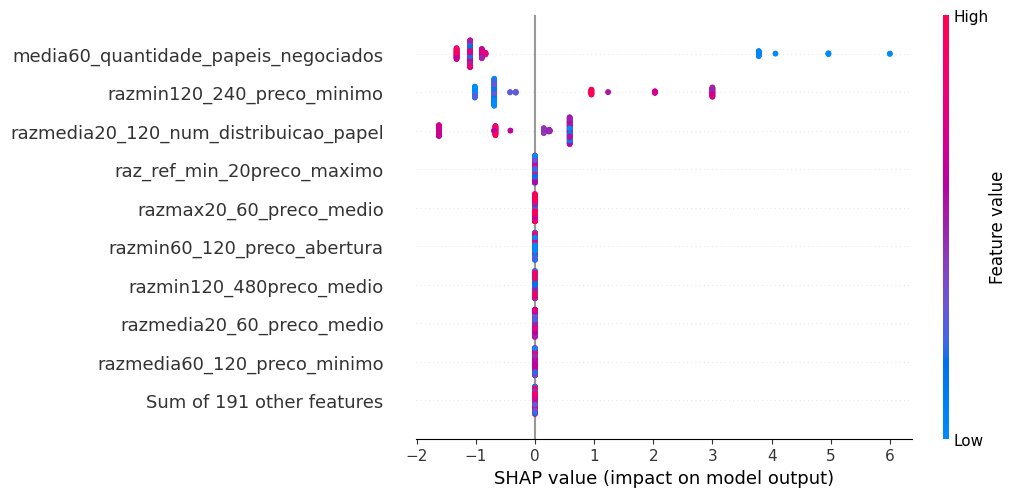

,Feature,Importance
8,media60_quantidade_papeis_negociados,0.664081
109,razmin120_240_preco_minimo,0.220850
11,razmedia20_120_num_distribuicao_papel,0.115069
0,quantidade_papeis_negociados,0.000000
4,raz_ref_min_60quantidade_papeis_negociados,0.000000
5,raz_ref_min_120quantidade_papeis_negociados,0.000000
2,razmedia20_60_quantidade_papeis_negociados,0.000000
1,numero_negocios_PETR4,0.000000
7,raz_ref_media_20quantidade_papeis_negociados,0.000000
6,razmedia20_120_quantidade_papeis_negociados,0.000000


In [140]:
# Obter importância das variáveis
feature_importances = modelo_final_charge.feature_importances_
features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Ordenar variáveis por importância
features = features.sort_values(by='Importance', ascending=False)
features


explainer = shap.TreeExplainer(modelo_final_charge)
shap_values = explainer(X_test)
# shap.summary_plot(shap_values, X_test)
shap.plots.beeswarm(shap_values,max_display=10)
features.head(10)

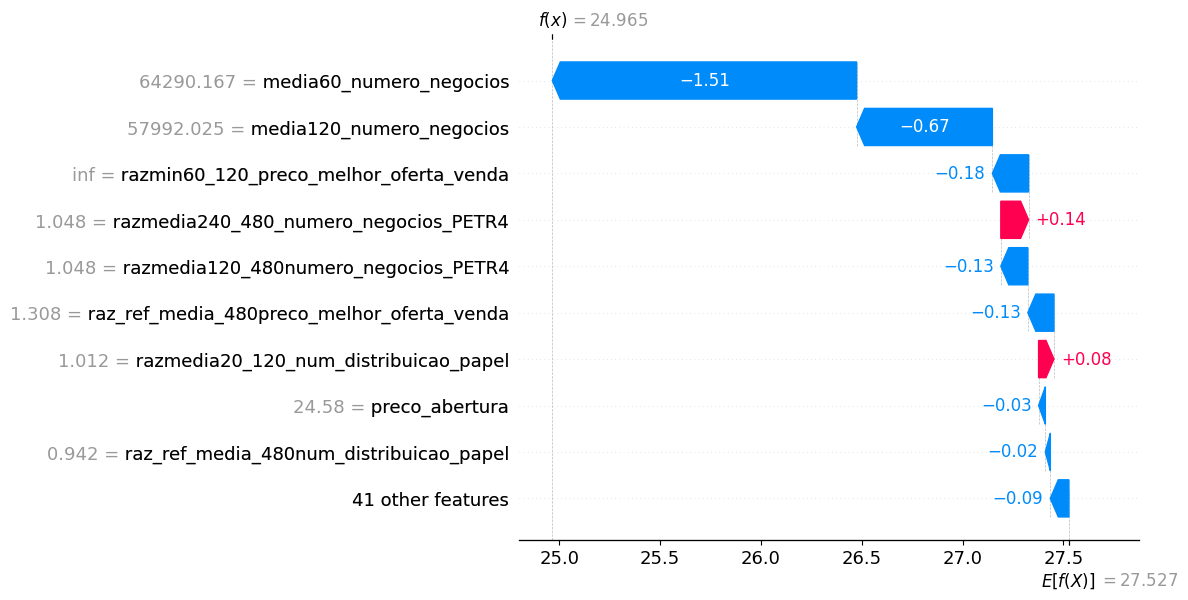

In [82]:
shap.plots.waterfall(shap_values[10],max_display=10)



In [ ]:
from scipy.stats import ks_2samp

# Suponha que temos duas amostras
amostra1 = [22, 21, 20, 23, 22, 14, 25]
amostra2 = [22, 11, 0, 23, 22, 24, 24]

estatistica, p_valor = ks_2samp(amostra1, amostra2)
print(f'Estatística KS: {estatistica}, p-valor: {p_valor}')

Estatística KS: 0.2857142857142857, p-valor: 0.9627039627039629


In [ ]:
def calculate_psi_categorical(expected, actual, plot=False):
    """
    Calcula o PSI (Population Stability Index) para variáveis categóricas.

    Parameters:
    - expected: array-like (lista, pandas Series, numpy array) → Distribuição de referência (ex.: dados históricos)
    - actual: array-like (lista, pandas Series, numpy array) → Nova distribuição (ex.: novos dados)

    Returns:
    - PSI value (quanto maior, maior a diferença entre as distribuições)
    """

    # Criar DataFrames para contar a frequência das categorias
    expected_counts = pd.Series(expected).value_counts(normalize=True)  # Frequências relativas
    actual_counts = pd.Series(actual).value_counts(normalize=True)

    # Garantir que todas as categorias da distribuição esperada estejam na distribuição atual
    all_categories = set(expected_counts.index).union(set(actual_counts.index))

    # Criar DataFrames com todas as categorias, preenchendo 0 onde não houver valores
    expected_perc = expected_counts.reindex(all_categories, fill_value=0.0001)
    actual_perc = actual_counts.reindex(all_categories, fill_value=0.0001)

    # Calcular PSI
    psi_values = (expected_perc - actual_perc) * np.log(expected_perc / actual_perc)
    psi = sum(psi_values)

    df_plot = pd.DataFrame({"Categoria": list(all_categories),
                            "Esperado": expected_perc.values,
                            "Atual": actual_perc.values})
    df_plot = df_plot.melt(id_vars="Categoria", var_name="Tipo", value_name="Proporção")

    # Plotando o gráfico
    if plot:
        plt.figure(figsize=(10, 5))
        sns.barplot(data=df_plot, x="Categoria", y="Proporção", hue="Tipo", palette=["blue", "red"])
        plt.title(f"Comparação das Distribuições Categóricas (PSI = {psi:.4f})")
        plt.xlabel("Categorias")
        plt.ylabel("Proporção")
        plt.legend(title="Distribuição")
        plt.grid(axis="y", linestyle="--", alpha=0.5)
        plt.show()
    return psi

# Exemplo de uso

def calculate_ks(expected, actual, plot=False):
    """
    Calcula e plota o KS (Kolmogorov-Smirnov) para variáveis contínuas.

    Parameters:
    - expected: array-like (lista, pandas Series, numpy array) → Distribuição de referência (ex.: dados históricos)
    - actual: array-like (lista, pandas Series, numpy array) → Nova distribuição (ex.: novos dados)
    - plot: bool → Se True, exibe o gráfico comparando distribuições

    Returns:
    - KS estatística (float) → Maior diferença entre as distribuições acumuladas
    - p-valor (float) → Probabilidade de que as distribuições sejam semelhantes
    """

    # Aplicar o teste KS
    estatistica_ks, p_valor = ks_2samp(expected, actual)

    if plot:
        plt.figure(figsize=(10, 5))
        sns.kdeplot(expected, label="Esperado", shade=True, color="blue", bw_adjust=1.2)
        sns.kdeplot(actual, label="Atual", shade=True, color="red", bw_adjust=1.2)

        plt.title(f"Comparação KDE das Distribuições (KS = {estatistica_ks:.4f}, p-valor = {p_valor:.4f})")
        plt.xlabel("Valor")
        plt.ylabel("Densidade")
        plt.legend(title="Distribuição")
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.show()

    return estatistica_ks, p_valor
resultados_ks = {
    'Variável': [],
    'Estatística KS': [],
    'p-valor': []
}

# ks_stat, p_value = calculate_ks_continuous(data_train['quantidade_papeis_negociados'], data_test['quantidade_papeis_negociados'])
# print(f"Estatística KS: {ks_stat:.4f}, p-valor: {p_value:.4f}")

# psi_result = calculate_psi_categorical(data_train['especificacao_papel'], data_validacao['especificacao_papel'])
# print(f"PSI para variável categórica: {psi_result:.4f}")


for var in selected_features:
    ks_stat, p_value = calculate_ks(data_train[var], data_test[var], plot=False)

    # Armazenar os resultados no dicionário
    resultados_ks['Variável'].append(var)
    resultados_ks['Estatística KS'].append(ks_stat)
    resultados_ks['p-valor'].append(p_value)

# Converter o dicionário para um DataFrame
df_resultados_ks = pd.DataFrame(resultados_ks)


features = df_resultados_ks.sort_values(by='Estatística KS', ascending=False)
features

,Variável,Estatística KS,p-valor
36,media240_quantidade_papeis_negociados,1.000000,1.720448e-132
29,media240_numero_negocios,0.997315,8.862027e-129
26,razmedia240_480_numero_negocios,0.997315,8.862027e-129
42,num_distribuicao_papel,0.980000,5.378934e-115
13,preco_abertura,0.953020,4.828523e-100
48,media60_quantidade_papeis_negociados,0.942282,1.201419e-95
34,preco_maximo,0.939597,1.275224e-94
11,razmedia120_480quantidade_papeis_negociados,0.930201,3.191156e-91
38,razmedia120_480numero_negocios,0.923490,5.911236e-89
10,preco_melhor_oferta_venda,0.921678,1.626356e-88


   id categoria  valor descricao
0   1         A    100     Item1
1   2         B    200     Item2
2   3         A    150     Item3
3   4         C    300     Item4
4   5         B    250     Item5
